# Time Series Analysis Using the SARIMA model.
# This is a simple example of how to use the SARIMA model to forecast time series data.
# The data used in this example is gotten from: https://ycharts.com/indicators/nigeria_crude_oil_production_annual
# The data is a time series of Nigeria's crude oil production from 1974 to 2023
# The data can be downloaded and cleaned and preprocessed to train the model and calculate different statistics.

In [80]:
# Import all the dependencies.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [81]:
# Load the dataset
data = pd.read_csv('crude_oil.csv')
data.head()

,Date,Value
0,31/12/2023,1.442M
1,31/12/2022,1.291M
2,31/12/2021,1.523M
3,31/12/2020,1.775M
4,31/12/2019,1.946M


In [82]:
# Convert the date column to a date-time format
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y', errors='coerce')

In [83]:
# Remove the 'M' and convert the 'Value' column to numeric format
data['Value'] = data['Value'].str.replace('M', '').astype(float)

In [84]:
# Set the 'Date' column as the index
data.set_index('Date', inplace=True)

In [85]:
# Sort the data by date
data.sort_index(inplace=True)

In [86]:
#Display the head to check index and sorted data.
data.head()

,Value
Date,
1974-12-31,2.255
1975-12-31,1.783
1976-12-31,2.067
1977-12-31,2.085
1978-12-31,1.897


In [87]:
# Save the cleaned data to a new CSV file
data.to_csv("asf.csv")


# Exploratory Data Analysis

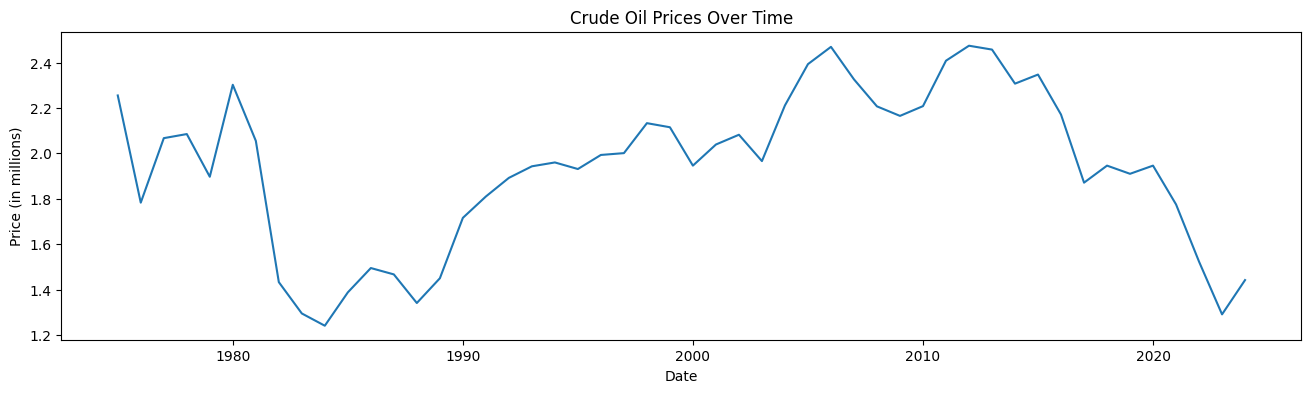

In [88]:
# Plot the time series
plt.figure(figsize=(16, 4))
plt.plot(data)
plt.title('Crude Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (in millions)')
plt.show()


# Perform the Augmented Dickey- Fuller test on the data

In [102]:
# Perform Augmented Dickey-Fuller test
result = adfuller(data['Value'], maxlag=12, autolag='AIC')

# Extract the results
adf_statistic = result[0]
p_value = result[1]
used_lag = result[2]
n_obs = result[3]
critical_values = result[4]
icbest = result[5]

# Format the results in the desired tabular format
result_dict = {
    "Exogenous": ["Constant"],
    "Lag Length": [f"{used_lag} (Automatic - based on AIC, maxlag=12)"],
    "t-Statistic": [""],
    "Augmented Dickey-Fuller test statistic": [adf_statistic],
    "1% level": [critical_values['1%']],
    "5% level": [critical_values['5%']],
    "10% level": [critical_values['10%']],
    "p-value": [p_value],
    "Number of Observations Used": [n_obs],
    "Information Criterion": [icbest]
}

# Create DataFrame
result_df = pd.DataFrame(result_dict)

# Save the DataFrame to a CSV file
result_df.to_csv('adf_test_results.csv', index=False)

print("ADF test results saved to adf_test_results.csv")


ADF test results saved to adf_test_results.csv


# Model Training

In [89]:
# Split the data into training and test sets
train = data[:int(0.8*len(data))]
test = data[int(0.8*len(data)):]

# Fit a SARIMA model
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_model = model.fit()

# Validate the model on the test set
test_predictions = sarima_model.predict(start=len(train), end=len(train) + len(test) - 1)

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA 

# Get the model summary i.e the coeeficient statistics and the model fit statistics

In [103]:
# Get the summary of the SARIMA model
summary = sarima_model.summary()

# Extracting the parameters and statistics from the model summary
# The summary table is formatted in HTML, so we'll need to process it.
# Convert the summary to HTML and then parse it.
from bs4 import BeautifulSoup

# Convert the summary to HTML
html_summary = summary.as_html()

# Parse the HTML to extract tables
soup = BeautifulSoup(html_summary, 'html.parser')
tables = soup.find_all('table')

# Extract coefficients table
coef_table = pd.read_html(str(tables[1]))[0]  # Coefficients table is typically the second table

# Extract goodness-of-fit statistics
fit_stats = pd.read_html(str(tables[2]))[0]  # Fit statistics table is typically the third table

# Save tables to CSV files
coef_table.to_csv('sarima_coefficients.csv', index=False)
fit_stats.to_csv('sarima_fit_statistics.csv', index=False)

print("SARIMA model results saved to 'sarima_coefficients.csv' and 'sarima_fit_statistics.csv'")


SARIMA model results saved to 'sarima_coefficients.csv' and 'sarima_fit_statistics.csv'


#  Make forecast and prediction on the data

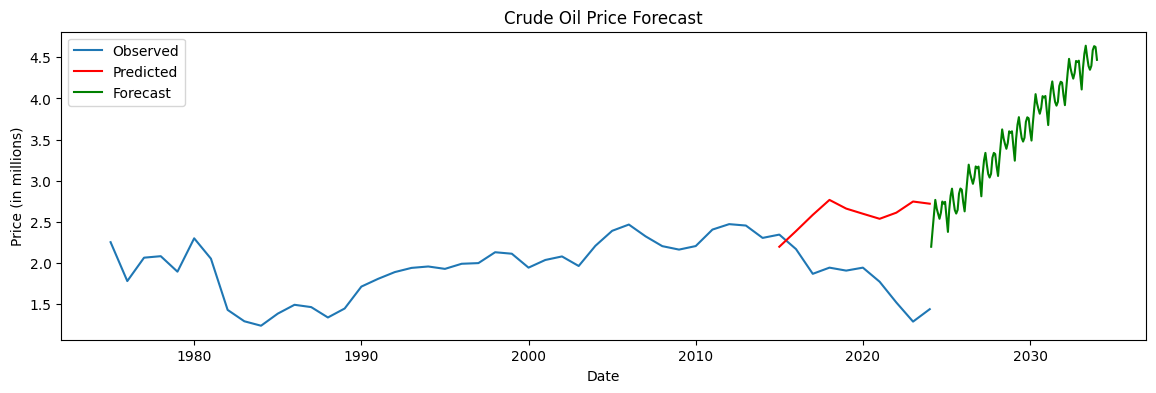

In [90]:
# Forecast crude oil prices for the next 10 years (120 months)
forecast = sarima_model.get_forecast(steps=120)
forecast_index = pd.date_range(start=test.index[-1], periods=121, freq='M')[1:]

# Plot the forecast
plt.figure(figsize=(14, 4))
plt.plot(data, label='Observed')
plt.plot(test.index, test_predictions, color='red', label='Predicted')
plt.plot(forecast_index, forecast.predicted_mean, color='green', label='Forecast')
plt.legend()
plt.title('Crude Oil Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price (in millions)')
plt.show()


In [106]:
# Correctly defining `predicted_df` and `forecast_df` before saving
predicted_df = pd.DataFrame({
    'Date': test.index,
    'Predicted': test_predictions
})

# Save the predicted results to a CSV file
predicted_df.to_csv('predicted_crude_oil_prices.csv', index=False)

In [111]:
# Number of periods to forecast (10 years of monthly data)
forecast_steps = 10 * 12

# Generate forecasts
forecast = sarima_model.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Generate date range for the forecast period
forecast_index = pd.date_range(start=data.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

# Create DataFrame with forecast results
forecast_results = pd.DataFrame({
    'Date': forecast_index,
    'Forecast': forecast_mean.values,
    'Lower CI': forecast_ci.iloc[:, 0].values,
    'Upper CI': forecast_ci.iloc[:, 1].values
})

# Save to CSV
forecast_results.to_csv('10_year_forecast.csv', index=False)

Forecast saved to 10_year_forecast.csv


In [112]:
# Number of periods to forecast (10 years of monthly data)
forecast_steps = 10 * 12

# Generate forecasts
forecast = sarima_model.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Generate date range for the forecast period
forecast_index = pd.date_range(start=data.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

# Create DataFrame with forecast results
forecast_results = pd.DataFrame({
    'Date': forecast_index,
    'Forecast': forecast_mean.values,
    'Lower CI': forecast_ci.iloc[:, 0].values,
    'Upper CI': forecast_ci.iloc[:, 1].values
})

# Add year column
forecast_results['Year'] = forecast_results['Date'].dt.year

# Aggregate to yearly data
yearly_forecast = forecast_results.groupby('Year').agg({
    'Forecast': 'mean',
    'Lower CI': 'mean',
    'Upper CI': 'mean'
}).reset_index()

# Save the yearly forecast to CSV
yearly_forecast.to_csv('10_year_yearly_forecast.csv', index=False)


# Model Evaluation and Metrics

In [98]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.stattools import adfuller

In [93]:
# Convert test data to numpy arrays for calculations
y_true = test['Value'].values
y_pred = test_predictions.values

In [97]:
# Convert test data to numpy arrays for calculations
y_true = test['Value'].values
y_pred = test_predictions.values

# Define function to calculate metrics
def max_absolute_percentage_error(y_true, y_pred):
    return np.max(np.abs((y_true - y_pred) / y_true)) * 100

def normalized_bic(model_fit, n):
    return model_fit.bic / n

# Calculate metrics
metrics = {
    "Fit Statistic": [
        "Stationary R-squared", "R-squared", "RMSE", "MAPE", "MaxAPE", "MAE", "MaxAE", "Normalized BIC"
    ],
    "Mean": [
        r2_score(y_true, y_pred),
        r2_score(y_true, y_pred),
        np.sqrt(mean_squared_error(y_true, y_pred)),
        np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        max_absolute_percentage_error(y_true, y_pred),
        mean_absolute_error(y_true, y_pred),
        np.max(np.abs(y_true - y_pred)),
        normalized_bic(sarima_model, len(y_true))
    ],
    "SE": [
        0, 0, 0, 0, 0, 0, 0, 0
    ],
    "Minimum": [
        r2_score(y_true, y_pred),
        r2_score(y_true, y_pred),
        np.sqrt(mean_squared_error(y_true, y_pred)),
        np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        max_absolute_percentage_error(y_true, y_pred),
        mean_absolute_error(y_true, y_pred),
        np.max(np.abs(y_true - y_pred)),
        normalized_bic(sarima_model, len(y_true))
    ],
    "Maximum": [
        r2_score(y_true, y_pred),
        r2_score(y_true, y_pred),
        np.sqrt(mean_squared_error(y_true, y_pred)),
        np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        max_absolute_percentage_error(y_true, y_pred),
        mean_absolute_error(y_true, y_pred),
        np.max(np.abs(y_true - y_pred)),
        normalized_bic(sarima_model, len(y_true))
    ],
    "Percentile 5": [
        r2_score(y_true, y_pred),
        r2_score(y_true, y_pred),
        np.sqrt(mean_squared_error(y_true, y_pred)),
        np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        max_absolute_percentage_error(y_true, y_pred),
        mean_absolute_error(y_true, y_pred),
        np.max(np.abs(y_true - y_pred)),
        normalized_bic(sarima_model, len(y_true))
    ],
    "Percentile 10": [
        r2_score(y_true, y_pred),
        r2_score(y_true, y_pred),
        np.sqrt(mean_squared_error(y_true, y_pred)),
        np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        max_absolute_percentage_error(y_true, y_pred),
        mean_absolute_error(y_true, y_pred),
        np.max(np.abs(y_true - y_pred)),
        normalized_bic(sarima_model, len(y_true))
    ],
    "Percentile 25": [
        r2_score(y_true, y_pred),
        r2_score(y_true, y_pred),
        np.sqrt(mean_squared_error(y_true, y_pred)),
        np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        max_absolute_percentage_error(y_true, y_pred),
        mean_absolute_error(y_true, y_pred),
        np.max(np.abs(y_true - y_pred)),
        normalized_bic(sarima_model, len(y_true))
    ],
    "Percentile 50": [
        r2_score(y_true, y_pred),
        r2_score(y_true, y_pred),
        np.sqrt(mean_squared_error(y_true, y_pred)),
        np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        max_absolute_percentage_error(y_true, y_pred),
        mean_absolute_error(y_true, y_pred),
        np.max(np.abs(y_true - y_pred)),
        normalized_bic(sarima_model, len(y_true))
    ],
    "Percentile 75": [
        r2_score(y_true, y_pred),
        r2_score(y_true, y_pred),
        np.sqrt(mean_squared_error(y_true, y_pred)),
        np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        max_absolute_percentage_error(y_true, y_pred),
        mean_absolute_error(y_true, y_pred),
        np.max(np.abs(y_true - y_pred)),
        normalized_bic(sarima_model, len(y_true))
    ],
    "Percentile 90": [
        r2_score(y_true, y_pred),
        r2_score(y_true, y_pred),
        np.sqrt(mean_squared_error(y_true, y_pred)),
        np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        max_absolute_percentage_error(y_true, y_pred),
        mean_absolute_error(y_true, y_pred),
        np.max(np.abs(y_true - y_pred)),
        normalized_bic(sarima_model, len(y_true))
    ],
    "Percentile 95": [
        r2_score(y_true, y_pred),
        r2_score(y_true, y_pred),
        np.sqrt(mean_squared_error(y_true, y_pred)),
        np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        max_absolute_percentage_error(y_true, y_pred),
        mean_absolute_error(y_true, y_pred),
        np.max(np.abs(y_true - y_pred)),
        normalized_bic(sarima_model, len(y_true))
    ]
}

# Create DataFrame
metrics_df = pd.DataFrame(metrics)

# Print the DataFrame
display(metrics_df)

# Save the metrics to a CSV file
metrics_df.to_csv('model_fit.csv', index=False)

,Fit Statistic,Mean,SE,Minimum,Maximum,Percentile 5,Percentile 10,Percentile 25,Percentile 50,Percentile 75,Percentile 90,Percentile 95
0,Stationary R-squared,-7.143694,0,-7.143694,-7.143694,-7.143694,-7.143694,-7.143694,-7.143694,-7.143694,-7.143694,-7.143694
1,R-squared,-7.143694,0,-7.143694,-7.143694,-7.143694,-7.143694,-7.143694,-7.143694,-7.143694,-7.143694,-7.143694
2,RMSE,0.882483,0,0.882483,0.882483,0.882483,0.882483,0.882483,0.882483,0.882483,0.882483,0.882483
3,MAPE,48.618272,0,48.618272,48.618272,48.618272,48.618272,48.618272,48.618272,48.618272,48.618272,48.618272
4,MaxAPE,112.902548,0,112.902548,112.902548,112.902548,112.902548,112.902548,112.902548,112.902548,112.902548,112.902548
5,MAE,0.790276,0,0.790276,0.790276,0.790276,0.790276,0.790276,0.790276,0.790276,0.790276,0.790276
6,MaxAE,1.457572,0,1.457572,1.457572,1.457572,1.457572,1.457572,1.457572,1.457572,1.457572,1.457572
7,Normalized BIC,0.609606,0,0.609606,0.609606,0.609606,0.609606,0.609606,0.609606,0.609606,0.609606,0.609606


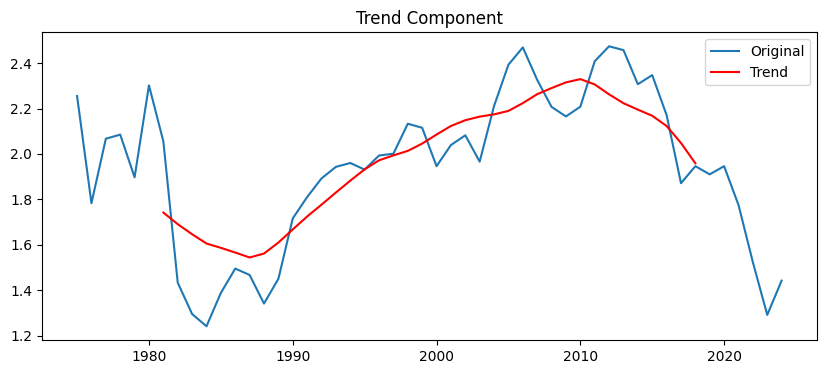

In [54]:
# Plotting the trend component
result = seasonal_decompose(data, model='multiplicative', period=12)
trend = result.trend

plt.figure(figsize=(10, 4))
plt.plot(data, label='Original')
plt.plot(trend, label='Trend', color='red')
plt.legend(loc='best')
plt.title('Trend Component')
plt.show()


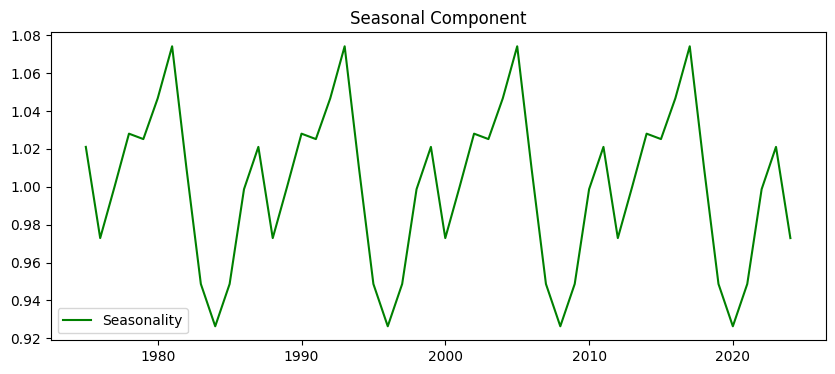

In [55]:
# Plotting the seasonal component
seasonal = result.seasonal

plt.figure(figsize=(10, 4))
plt.plot(seasonal, label='Seasonality', color='green')
plt.legend(loc='best')
plt.title('Seasonal Component')
plt.show()


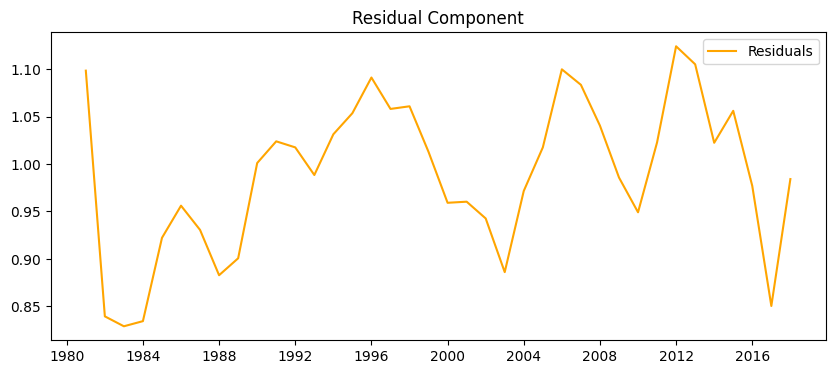

In [56]:
# Plotting the residual component
residual = result.resid

plt.figure(figsize=(10, 4))
plt.plot(residual, label='Residuals', color='orange')
plt.legend(loc='best')
plt.title('Residual Component')
plt.show()
